In [7]:
import pandas as pd
import os 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
import numpy as np
import statsmodels.api as sm
from statsmodels.nonparametric.kernel_regression import KernelReg

In [8]:
#Leer los datos y filtrar los datos de interes
df = pd.read_csv(os.path.join("top_aerolinea.csv"))
df = df[df.Nombre_Empresa_clean == "AVIANCA"].copy()
df["Fecha"] = pd.to_datetime(df["Fecha"])
df = df.sort_values("Fecha")
df = df.drop(columns=["Nombre_Empresa_clean"])

In [9]:
# Se filtran solo los ultimos 10 años 
ind_year = df.Fecha.dt.year >= 2013
df = df[ind_year].copy()

In [10]:
#Se adiciona un lag -1 como variable explicativa
df_m1 = df.copy()
df_m1["lag1"] = df_m1.pasajeros.shift()
df_m1.dropna(inplace =True)
df_m1.reset_index(drop=True, inplace=True)
#df.set_index("Fecha", inplace=True)

In [11]:
#Se define el punto de corte entre train y test
ind_corte = df_m1.Fecha[(df_m1.Fecha ==pd.to_datetime("2022-01-01"))].index[0]  #pd.to_datetime("2022-01-01")
X_1 = df_m1.loc[:,["lag1"]]
y = df_m1.loc[:,["pasajeros"]]

In [12]:
#Se genera un dataframe para almacenar los resultados
results_df_m1 = df_m1.loc[:,["pasajeros", "Fecha"]].copy()
results_df_m1.set_index("Fecha", inplace=True)

In [13]:
#Se entrena un modelo de regresion lineal simple
model_1 = LinearRegression().fit(X_1.iloc[:ind_corte].values,
                             	y.iloc[:ind_corte].values)

c:\Users\franc\miniconda3\envs\ta\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


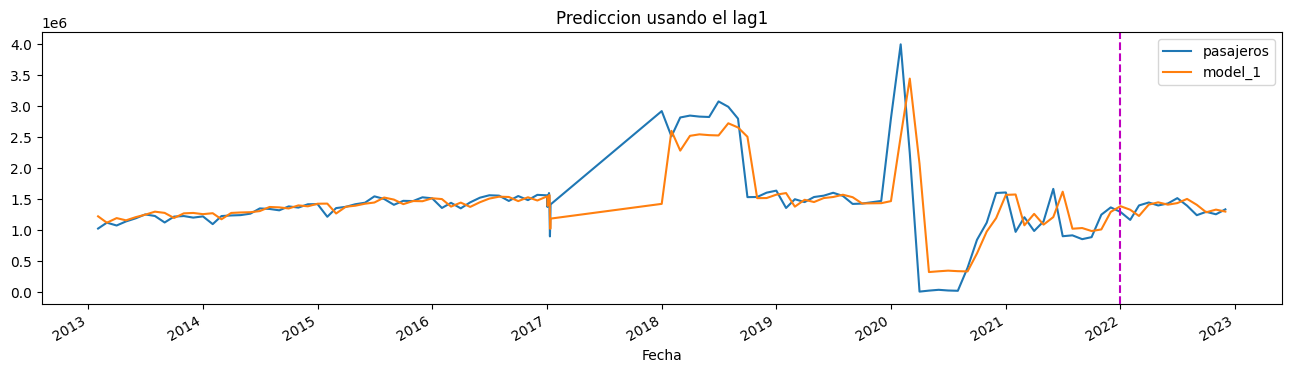

In [14]:
#Se grafica el resultado con un modelo de regresión simple
results_df_m1["model_1"] = model_1.predict(X_1)
results_df_m1[["pasajeros", "model_1"]].plot(figsize=(16,4),
                                    	title="Prediccion usando el lag1")
plt.axvline(pd.to_datetime("2022-01-01"), c="m", linestyle="--");

In [15]:
mape1 = mean_absolute_percentage_error(results_df_m1["pasajeros"], results_df_m1["model_1"])
mae1 = mean_absolute_error(results_df_m1["pasajeros"], results_df_m1["model_1"])
rmse1 = np.sqrt(mean_squared_error(results_df_m1["pasajeros"], results_df_m1["model_1"]))

print(f"MAPE: {mape1}")
print(f"MAE: {mae1}")
print(f"RMSE: {rmse1}")

MAPE: 23.73690966775086
MAE: 189532.62471387308
RMSE: 376167.6101375368


**Lag12**


c:\Users\franc\miniconda3\envs\ta\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


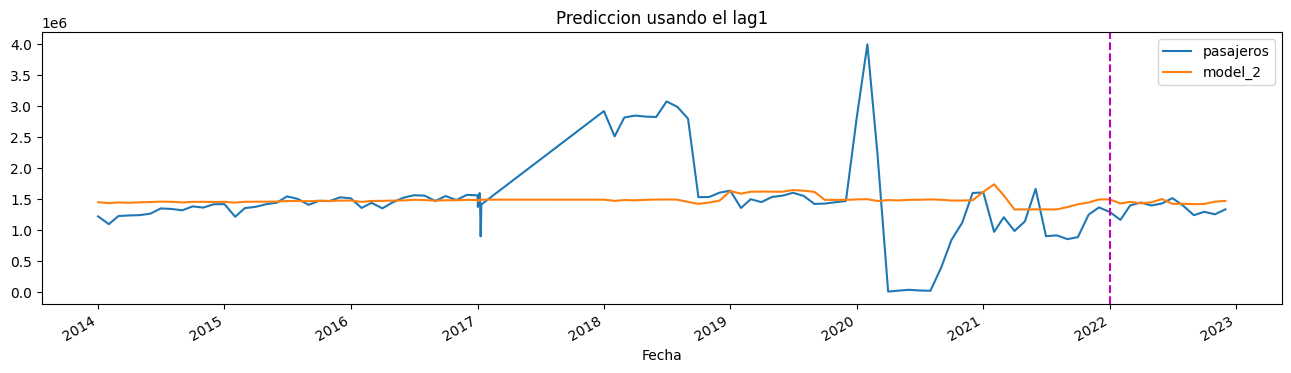

In [16]:
#Se adiciona un lag -12 como variable explicativa
df_m2 = df.copy()
df_m2["lag12"] = df_m2.pasajeros.shift(12)
df_m2.dropna(inplace =True)
df_m2.reset_index(drop=True, inplace=True)


#Se define el punto de corte entre train y test
ind_corte = df_m2.Fecha[(df_m2.Fecha ==pd.to_datetime("2022-01-01"))].index[0]  #pd.to_datetime("2022-01-01")
X_2 = df_m2.loc[:,["lag12"]]
y = df_m2.loc[:,["pasajeros"]]

#Se genera un dataframe para almacenar los resultados
results_df_m2 = df_m2.loc[:,["pasajeros", "Fecha"]].copy()
results_df_m2.set_index("Fecha", inplace=True)

#Se entrena un modelo de regresion lineal simple
model_2 = LinearRegression().fit(X_2.iloc[:ind_corte].values,
                             	y.iloc[:ind_corte].values)

#Se grafica el resultado con un modelo de regresión simple
results_df_m2["model_2"] = model_2.predict(X_2)
results_df_m2[["pasajeros", "model_2"]].plot(figsize=(16,4),
                                    	title="Prediccion usando el lag1")
plt.axvline(pd.to_datetime("2022-01-01"), c="m", linestyle="--");

In [17]:
mape2 = mean_absolute_percentage_error(results_df_m2["pasajeros"], results_df_m2["model_2"])
mae2 = mean_absolute_error(results_df_m2["pasajeros"], results_df_m2["model_2"])
rmse2 = np.sqrt(mean_squared_error(results_df_m2["pasajeros"], results_df_m2["model_2"]))

print(f"MAPE: {mape2}")
print(f"MAE: {mae2}")
print(f"RMSE: {rmse2}")

MAPE: 21.38748756162095
MAE: 361645.0472177428
RMSE: 623475.9132085467


**Se visualiza que el modelo se ajusta muy bien debido a la poca variabilidad de los datos anteriores**

**M-estimadores**

In [18]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.robust.scale import mad
np.random.seed(42) 

In [19]:
df_rob = df_m2.copy()
df_rob.columns=["Fecha","Y","X"]

In [20]:

# Calcular las medianas de las variables
median_y = np.median(df_rob['Y'].iloc[:ind_corte])
median_x = np.median(df_rob['X'].iloc[:ind_corte])

# Calcular los pesos robustos utilizando M-estimadores y MAD
weights = np.abs(df_rob['Y'].iloc[:ind_corte] - median_y) / mad(df_rob['Y'].iloc[:ind_corte])

# Crear el modelo de regresión robusta utilizando M-estimadores y MAD
model = sm.RLM(df_rob['Y'].iloc[:ind_corte], sm.add_constant(df_rob['X'].iloc[:ind_corte]), M=sm.robust.norms.HuberT(), weights=weights).fit()

# Calcular las predicciones del modelo
pred_rob1 = model.predict(sm.add_constant(df_rob['X']))


c:\Users\franc\miniconda3\envs\ta\lib\site-packages\statsmodels\base\model.py:127: ValueWarning: unknown kwargs ['weights']
  warnings.warn(msg, ValueWarning)


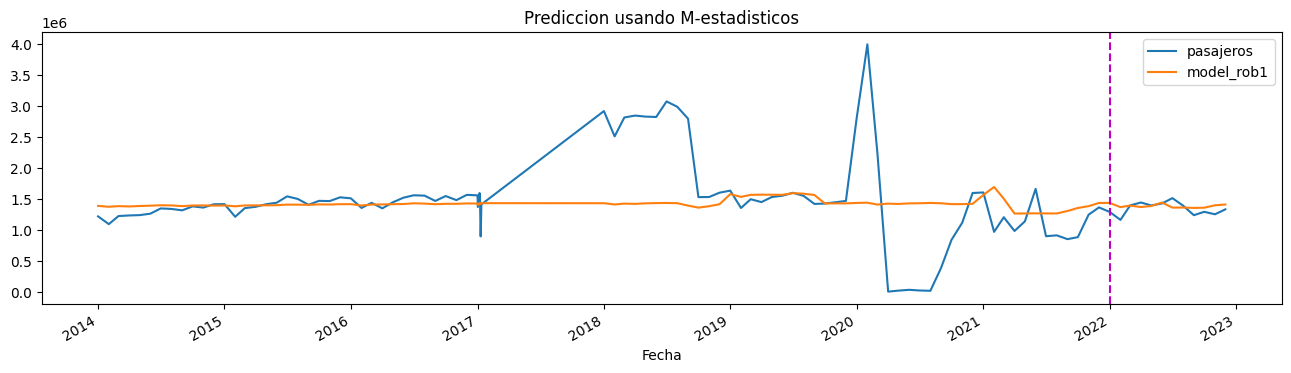

In [21]:
#Se grafica el resultado con un modelo de regresión simple
results_df_m2["model_rob1"] = pred_rob1.values
results_df_m2[["pasajeros", "model_rob1"]].plot(figsize=(16,4),
                                    	title="Prediccion usando M-estadisticos")
plt.axvline(pd.to_datetime("2022-01-01"), c="m", linestyle="--");

In [22]:
mape3 = mean_absolute_percentage_error(results_df_m2["pasajeros"], results_df_m2["model_rob1"])
mae3 = mean_absolute_error(results_df_m2["pasajeros"], results_df_m2["model_rob1"])
rmse3 = np.sqrt(mean_squared_error(results_df_m2["pasajeros"], results_df_m2["model_rob1"]))

print(f"MAPE: {mape3}")
print(f"MAE: {mae3}")
print(f"RMSE: {rmse3}")

MAPE: 20.553968012435643
MAE: 352211.27092020644
RMSE: 625064.1849912375


**Hampel**

In [23]:
#Se ajusta el modelo robusto
rlm_model = sm.RLM(df_rob['Y'].iloc[:ind_corte], 
                   df_rob['X'].iloc[:ind_corte], 
                   M=sm.robust.norms.Hampel()).fit()

#Se generan las predicciones
pred_rob2 = rlm_model.predict(df_rob['X'])


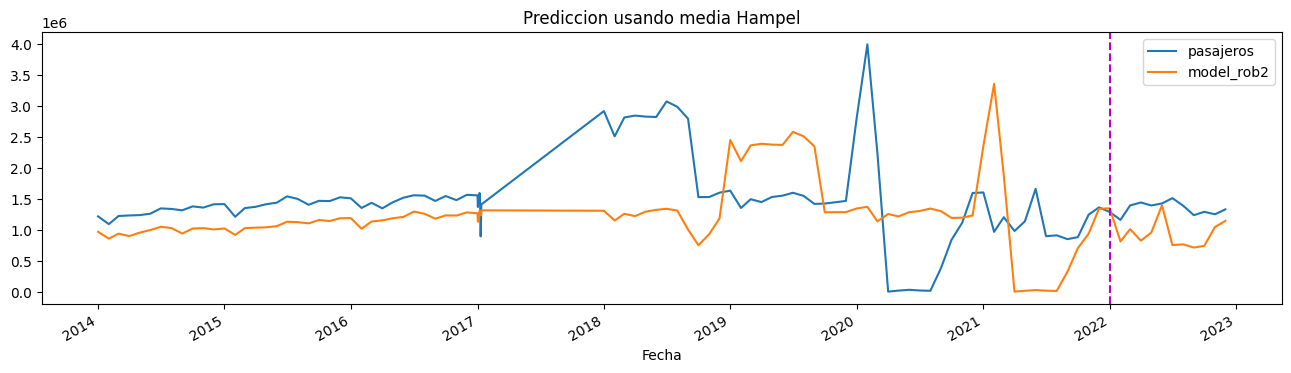

In [24]:
#Se grafica el resultado 
results_df_m2["model_rob2"] = pred_rob2.values
results_df_m2[["pasajeros", "model_rob2"]].plot(figsize=(16,4),
                                    	title="Prediccion usando media Hampel")
plt.axvline(pd.to_datetime("2022-01-01"), c="m", linestyle="--");

In [25]:
mape4 = mean_absolute_percentage_error(results_df_m2["pasajeros"], results_df_m2["model_rob2"])
mae4 = mean_absolute_error(results_df_m2["pasajeros"], results_df_m2["model_rob2"])
rmse4 = np.sqrt(mean_squared_error(results_df_m2["pasajeros"], results_df_m2["model_rob2"]))

print(f"MAPE: {mape4}")
print(f"MAE: {mae4}")
print(f"RMSE: {rmse4}")

MAPE: 18.401609752037952
MAE: 626405.9623706924
RMSE: 816268.4674728637


**Trimmed mean**


In [26]:
#Se ajusta el modelo robusto
rlm_model2 = sm.RLM(df_rob['Y'].iloc[:ind_corte], 
                   df_rob['X'].iloc[:ind_corte], 
                   M=sm.robust.norms.TrimmedMean()).fit()

#Se generan las predicciones
pred_rob3 = rlm_model2.predict(df_rob['X'])


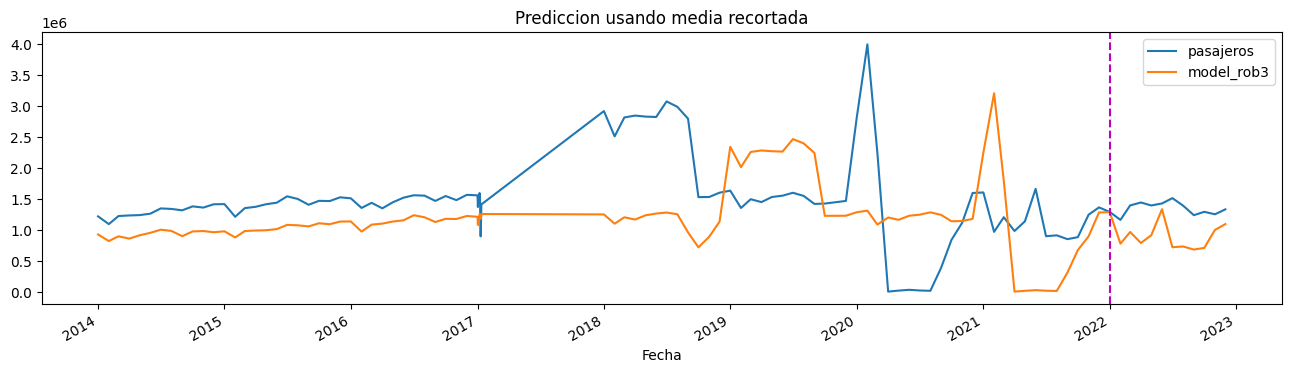

In [27]:
#Se grafica el resultado 
results_df_m2["model_rob3"] = pred_rob3.values
results_df_m2[["pasajeros", "model_rob3"]].plot(figsize=(16,4),
                                    	title="Prediccion usando media recortada")
plt.axvline(pd.to_datetime("2022-01-01"), c="m", linestyle="--");

In [28]:
mape5 = mean_absolute_percentage_error(results_df_m2["pasajeros"], results_df_m2["model_rob3"])
mae5 = mean_absolute_error(results_df_m2["pasajeros"], results_df_m2["model_rob3"])
rmse5 = np.sqrt(mean_squared_error(results_df_m2["pasajeros"], results_df_m2["model_rob3"]))

print(f"MAPE: {mape5}")
print(f"MAE: {mae5}")
print(f"RMSE: {rmse5}")

MAPE: 17.59563755863599
MAE: 644139.7731385861
RMSE: 821675.5556365496


**Kernel Regression**

In [29]:
_, pred = KernelReg(endog = df_rob['Y'], exog = df_rob['X'], var_type = 'c', reg_type = 'lc').fit()


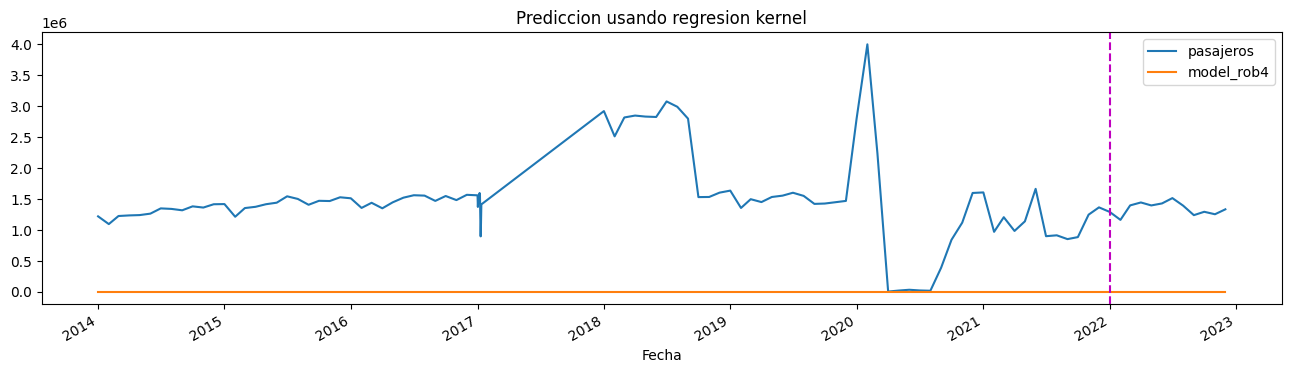

In [30]:
#Se grafica el resultado 
results_df_m2["model_rob4"] = pred
results_df_m2[["pasajeros", "model_rob4"]].plot(figsize=(16,4),
                                    	title="Prediccion usando regresion kernel")
plt.axvline(pd.to_datetime("2022-01-01"), c="m", linestyle="--");

In [31]:
mape6 = mean_absolute_percentage_error(results_df_m2["pasajeros"], results_df_m2["model_rob4"])
mae6 = mean_absolute_error(results_df_m2["pasajeros"], results_df_m2["model_rob4"])
rmse6 = np.sqrt(mean_squared_error(results_df_m2["pasajeros"], results_df_m2["model_rob4"]))

print(f"MAPE: {mape6}")
print(f"MAE: {mae6}")
print(f"RMSE: {rmse6}")

MAPE: 0.9999998964611899
MAE: 1463372.2278990687
RMSE: 1592099.7344043246
